In [2]:
import intake
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import pandas as pd

# TLDR

Get the data

In [3]:
catalog_file = "/home/k/k203123/NextGEMS_Cycle2.git/experiments/ngc2013/scripts/ngc2013.json"
cat = intake.open_esm_datastore(catalog_file)
final_query = cat.search(realm="atm", frequency='3hour', variable_id='tas')
dataset_dict = final_query.to_dataset_dict(
    cdf_kwargs={
        "chunks": dict(
            time=1,
            # height=1,
        )
    }
)
keys = list(dataset_dict.keys())
data = dataset_dict[keys[0]]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institution_id.source_id.experiment_id.simulation_id.realm.frequency.time_reduction.grid_label.level_type'


OSError: 
            Failed to open netCDF/HDF dataset.

            *** Arguments passed to xarray.open_dataset() ***:

            - filename_or_obj: /work/bm1235/k203123/experiments/ngc2013/run_20450401T000000-20450430T235845/ngc2013_atm_2d_3h_inst_20450501T000000Z.nc
            - kwargs: {'chunks': {'time': 1}}

            *** fsspec options used ***:

            - root: /work/bm1235/k203123/experiments/ngc2013/run_20450401T000000-20450430T235845/ngc2013_atm_2d_3h_inst_20450501T000000Z.nc
            - protocol: None

            ********************************************
            

Get the grid

In [6]:
grid_path = "/pool/data/ICON/grids/public/mpim/0015/icon_grid_0015_R02B09_G.nc"
grid = xr.open_dataset(grid_path)
model_lon_icon = grid.clon.values*180./np.pi
model_lat_icon = grid.clat.values*180./np.pi

Interpolate

In [7]:
lon = np.linspace(-30, 60, 90*10)
lat = np.linspace(33, 72, (72-33)*10)
lon2, lat2 = np.meshgrid(lon, lat)

points_icon = np.vstack((model_lon_icon, model_lat_icon)).T
data_sample = data.tas[1,0,:]

nn_interpolation = NearestNDInterpolator(points_icon, data_sample.values)
interpolated_nn = nn_interpolation((lon2, lat2))

Plot

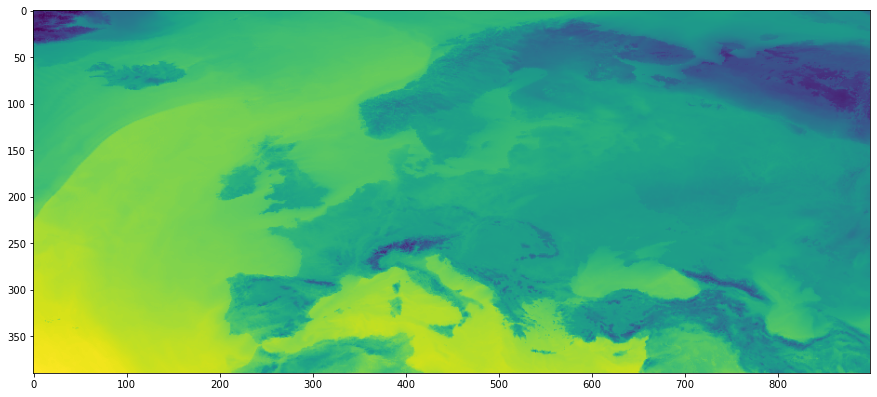

In [8]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn))

## Longer version

In [1]:
catalog_file = "/home/k/k203123/NextGEMS_Cycle2.git/experiments/ngc2013/scripts/ngc2013.json"

In [4]:
cat = intake.open_esm_datastore(catalog_file)
cat

In [5]:
def get_from_cat(catalog, columns):
    if type (columns) == type (""):
        columns = [columns]
    return catalog.df[columns].drop_duplicates().sort_values(columns)

In [6]:
pd.set_option("max_colwidth", None)
overview = get_from_cat(cat, ["experiment_id", "source_id", "realm", "frequency", "variable_id"])
overview

experiment_id source_id realm frequency  \
23   nextgems_cycle2  ICON-ESM   atm     12day   
25   nextgems_cycle2  ICON-ESM   atm     12day   
14   nextgems_cycle2  ICON-ESM   atm     12day   
16   nextgems_cycle2  ICON-ESM   atm     12day   
1    nextgems_cycle2  ICON-ESM   atm     12day   
12   nextgems_cycle2  ICON-ESM   atm     12day   
116  nextgems_cycle2  ICON-ESM   atm    1month   
119  nextgems_cycle2  ICON-ESM   atm    1month   
99   nextgems_cycle2  ICON-ESM   atm    1month   
102  nextgems_cycle2  ICON-ESM   atm    1month   
72   nextgems_cycle2  ICON-ESM   atm    1month   
96   nextgems_cycle2  ICON-ESM   atm    1month   
10   nextgems_cycle2  ICON-ESM   atm    23hour   
22   nextgems_cycle2  ICON-ESM   atm    23hour   
11   nextgems_cycle2  ICON-ESM   atm    23hour   
9    nextgems_cycle2  ICON-ESM   atm    23hour   
20   nextgems_cycle2  ICON-ESM   atm     3hour   
18   nextgems_cycle2  ICON-ESM   atm     3hour   
3    nextgems_cycle2  ICON-ESM   atm     3hour   
5    nextgems_cycle2  ICON-ESM   atm     3hour   
7    nextgems_cycle2  ICON-ESM   atm     3hour   
0    nextgems_cycle2  ICON-ESM   atm        fx   
71   nextgems_cycle2  ICON-ESM   oce     12day   
56   nextgems_cycle2  ICON-ESM   oce     12day   
57   nextgems_cycle2  ICON-ESM   oce     12day   
27   nextgems_cycle2  ICON-ESM   oce     12day   
54   nextgems_cycle2  ICON-ESM   oce      1day   
41   nextgems_cycle2  ICON-ESM   oce     1hour   
28   nextgems_cycle2  ICON-ESM   oce     1hour   
414  nextgems_cycle2  ICON-ESM   oce    1month   
315  nextgems_cycle2  ICON-ESM   oce    1month   
318  nextgems_cycle2  ICON-ESM   oce    1month   
122  nextgems_cycle2  ICON-ESM   oce    1month   
58   nextgems_cycle2  ICON-ESM   oce     3hour   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     variable_id  
23                                                                                                                                                                                                                                                                                                                                                                                                                  (hydro_discharge_ocean_box, hydro_drainage_box, hydro_runoff_box, hydro_transpiration_box, sse_grnd_hflx_old_box, hydro_canopy_cond_limited_box, hydro_w_snow_box, hydro_snow_soil_dens_box)  
25                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  (hydro_w_soil_sl_box, hydro_w_ice_sl_box, sse_t_soil_sl_box)  
14                                                                                                                                                                                                                                                                                                                                                                (psl, ps, sit, sic, tas, ts, uas, vas, cfh_lnd, sfcwind, clivi, cllvi, cptgzvi, hfls, hfss, prlr, pr, prw, qgvi, qrvi

In [8]:
cat.search(realm="atm", frequency='3hour', variable_id='tas')

In [9]:
final_query = cat.search(realm="atm", frequency='3hour', variable_id='tas')

In [13]:
final_query.to_dataset_dict

<bound method esm_datastore.to_dataset_dict of <ICON-ESM catalog with 1 dataset(s) from 579 asset(s)>>

In [10]:
dataset_dict = final_query.to_dataset_dict(
    cdf_kwargs={
        "chunks": dict(
            time=1,
            # height=1,
        )
    }
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institution_id.source_id.experiment_id.simulation_id.realm.frequency.time_reduction.grid_label.level_type'


OSError: 
            Failed to open netCDF/HDF dataset.

            *** Arguments passed to xarray.open_dataset() ***:

            - filename_or_obj: /work/bm1235/k203123/experiments/ngc2013/run_20350301T000000-20350531T235830/ngc2013_atm_2d_3h_inst_20350401T000000Z.nc
            - kwargs: {'chunks': {'time': 1}}

            *** fsspec options used ***:

            - root: /work/bm1235/k203123/experiments/ngc2013/run_20350301T000000-20350531T235830/ngc2013_atm_2d_3h_inst_20350401T000000Z.nc
            - protocol: None

            ********************************************
            

In [11]:
dataset_dict

NameError: name 'dataset_dict' is not defined

In [12]:
keys = list(dataset_dict.keys())
keys

['nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2009.atm.30minute.inst.gn.ml']

In [13]:
data = dataset_dict[keys[0]]
data

<xarray.Dataset>
Dimensions:  (time: 37009, height: 1, ncells: 20971520)
Coordinates:
  * height   (height) float64 2.0
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T00:30:00 ... 2022-03-01
Dimensions without coordinates: ncells
Data variables:
    tas      (time, height, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
Attributes: (12/13)
    intake_esm_varname:      ['tas']
    history:                 ./icon at 20220512 152214\n./icon at 20220512 19...
    CDI:                     Climate Data Interface version 1.8.3rc (http://m...
    number_of_grid_used:     15
    references:              see MPIM/DWD publications
    grid_file_uri:           http://icon-downloads.mpimet.mpg.de/grids/public...
    ...                      ...
    source:                  git@gitlab.dkrz.de:icon/icon-aes.git@87a1eaded69...
    title:                   ICON simulation
    Conventions:             CF-1.6
    institution:             Max Planck Institute for Meteorology/Deutscher W...
    uuidOfHGrid:             0f1e7d66-637e-11e8-913b-51232bb4d8f9
    intake_esm_dataset_key:  nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2009....

In [32]:
data_sample = data.tas[1,0,:]

In [33]:
data_sample

<xarray.DataArray 'tas' (ncells: 20971520)>
dask.array<getitem, shape=(20971520,), dtype=float32, chunksize=(20971520,), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
    time     datetime64[ns] 2020-01-20T00:30:00
Dimensions without coordinates: ncells
Attributes:
    standard_name:                tas
    long_name:                    temperature in 2m
    units:                        K
    param:                        0.0.0
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [34]:
data_sample.shape

(20971520,)

In [35]:
data_sample.values

array([256.32822, 255.8848 , 256.06198, ..., 282.19763, 282.13882,
       282.09595], dtype=float32)

In [36]:
grid_path = "/pool/data/ICON/grids/public/mpim/0015/icon_grid_0015_R02B09_G.nc"
grid = xr.open_dataset(grid_path)

Model Grid

In [37]:
model_lon_icon = grid.clon.values*180./np.pi
model_lat_icon = grid.clat.values*180./np.pi

In [38]:
model_lon_icon.shape

(20971520,)

Target grid

In [39]:
lon = np.linspace(-30, 60, 90*10)
lat = np.linspace(33, 72, (72-33)*10)
lon2, lat2 = np.meshgrid(lon, lat)

In [40]:
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator

In [41]:
points_icon = np.vstack((model_lon_icon, model_lat_icon)).T

In [42]:
nn_interpolation = NearestNDInterpolator(points_icon, data_sample.values)

In [43]:
interpolated_nn = nn_interpolation((lon2, lat2))

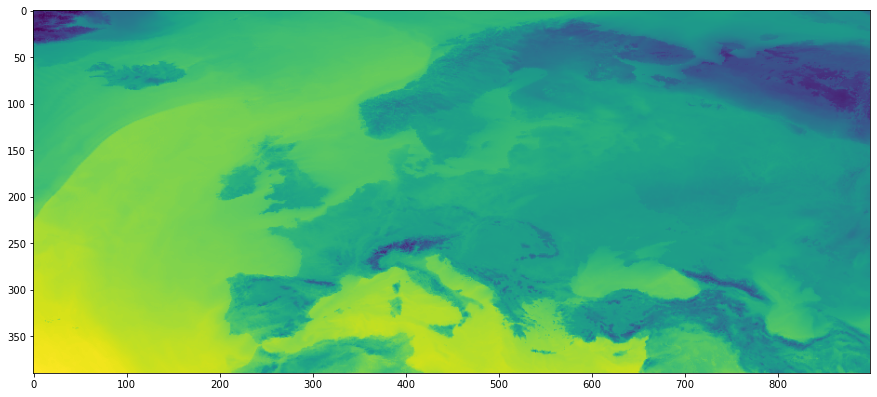

In [44]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn))

## Find point on the map

In [45]:
def tunnel_fast1d(latvar, lonvar, lonlat):
    """
    Find closest point in a set of (lat,lon) points to specified pointd.
    Parameters:
    -----------
        latvar : ndarray
            1d array with lats
        lonvar : ndarray
            1d array with lons
        lonlat : ndarray
            2d array with the shape of [2, number_of_point],
            that contain coordinates of the points
    Returns:
    --------
        node : int
            node number of the closest point
    Taken from here http://www.unidata.ucar.edu/blogs/developer/en/entry/accessing_netcdf_data_by_coordinates
    and modifyed for 1d
    """

    rad_factor = np.pi / 180.0  # for trignometry, need angles in radians
    # Read latitude and longitude from file into numpy arrays
    latvals = latvar[:] * rad_factor
    lonvals = lonvar[:] * rad_factor

    # Compute numpy arrays for all values, no loops
    clat, clon = np.cos(latvals), np.cos(lonvals)
    slat, slon = np.sin(latvals), np.sin(lonvals)

    clat_clon = clat * clon
    clat_slon = clat * slon

    lat0_rad = lonlat[1, :] * rad_factor
    lon0_rad = lonlat[0, :] * rad_factor

    delX_pre = np.cos(lat0_rad) * np.cos(lon0_rad)
    delY_pre = np.cos(lat0_rad) * np.sin(lon0_rad)
    delZ_pre = np.sin(lat0_rad)

    nodes = np.zeros((lonlat.shape[1]))
    for i in range(lonlat.shape[1]):
        delX = delX_pre[i] - clat_clon
        delY = delY_pre[i] - clat_slon
        delZ = delZ_pre[i] - slat
        dist_sq = delX ** 2 + delY ** 2 + delZ ** 2
        minindex_1d = dist_sq.argmin()  # 1D index of minimum element
        node = np.unravel_index(minindex_1d, latvals.shape)
        nodes[i] = node[0]

    return nodes.astype('int')

In [46]:
lon_target = -10
lat_target = 50

In [47]:
points = np.array([[lat_target],[lon_target]])

In [48]:
index = tunnel_fast1d(model_lon_icon, model_lat_icon, points)

In [49]:
model_lon_icon[index[0]]

-10.02962396505484

In [50]:
model_lat_icon[index[0]]

49.97659189571888

In [52]:
data.tas

<xarray.DataArray 'tas' (time: 37009, height: 1, ncells: 20971520)>
dask.array<concatenate, shape=(37009, 1, 20971520), dtype=float32, chunksize=(1, 1, 20971520), chunktype=numpy.ndarray>
Coordinates:
  * height   (height) float64 2.0
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T00:30:00 ... 2022-03-01
Dimensions without coordinates: ncells
Attributes:
    standard_name:                tas
    long_name:                    temperature in 2m
    units:                        K
    param:                        0.0.0
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [53]:
data.tas[:,0, index[0]]

<xarray.DataArray 'tas' (time: 37009)>
dask.array<getitem, shape=(37009,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T00:30:00 ... 2022-03-01
Attributes:
    standard_name:                tas
    long_name:                    temperature in 2m
    units:                        K
    param:                        0.0.0
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

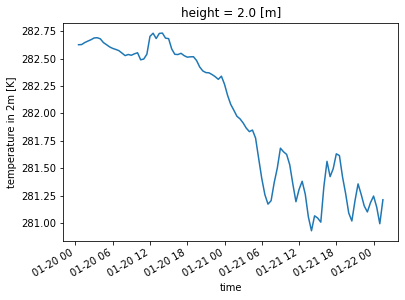

In [55]:
data.tas[1:100, 0, index[0]].plot()

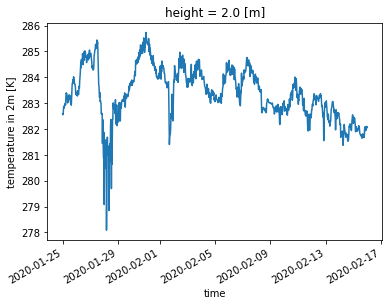

In [56]:
data.tas.sel(time=slice('2020-01-25','2020-02-15'))[:,0,index[0]].plot()